In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/tornikeo/Documents/uni/PRCV/proj


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from pathlib import Path
import random
import re

In [3]:
data = sorted(Path('training_data').glob('*.csv'))
labels = pd.Series(data).astype(str).str.extract(r".+stroke_(\d)_.+.csv").astype(int)
data = [pd.read_csv(d, header=None) for d in data]
lens = pd.Series([len(d) for d in data])

In [5]:
s = pd.DataFrame([d.std() for d in data])
pd.Series(np.argmax(s, 1)).value_counts(normalize=True)

1    0.984
0    0.015
2    0.001
Name: proportion, dtype: float64

In [6]:
s = pd.DataFrame([d.max() - d.min() for d in data])
pd.Series(np.argmax(s, 1)).value_counts(normalize=True)

1    0.965
0    0.034
2    0.001
Name: proportion, dtype: float64

In [7]:
s = pd.DataFrame([d.max() - d.min() for d in data])
pd.Series(np.argmax(s, 1)).value_counts(normalize=True)

1    0.965
0    0.034
2    0.001
Name: proportion, dtype: float64

In [8]:
s = pd.DataFrame([d.quantile(.75) - d.quantile(.25) for d in data])
pd.Series(np.argmax(s, 1)).value_counts(normalize=True)

1    0.970
0    0.027
2    0.003
Name: proportion, dtype: float64

In [9]:
# n = round(1000 ** .5)
# fig, ax = plt.subplots(n,n, figsize=(14,14))
# for d,axis in zip(data, ax.ravel()):
#     axis.plot(d[0],d[1])
#     axis.axis('off')

In [10]:
mnist_x = np.load('tornikeo/mnist_digits.npy')
mnist_y = np.load('tornikeo/mnist_targets.npy')

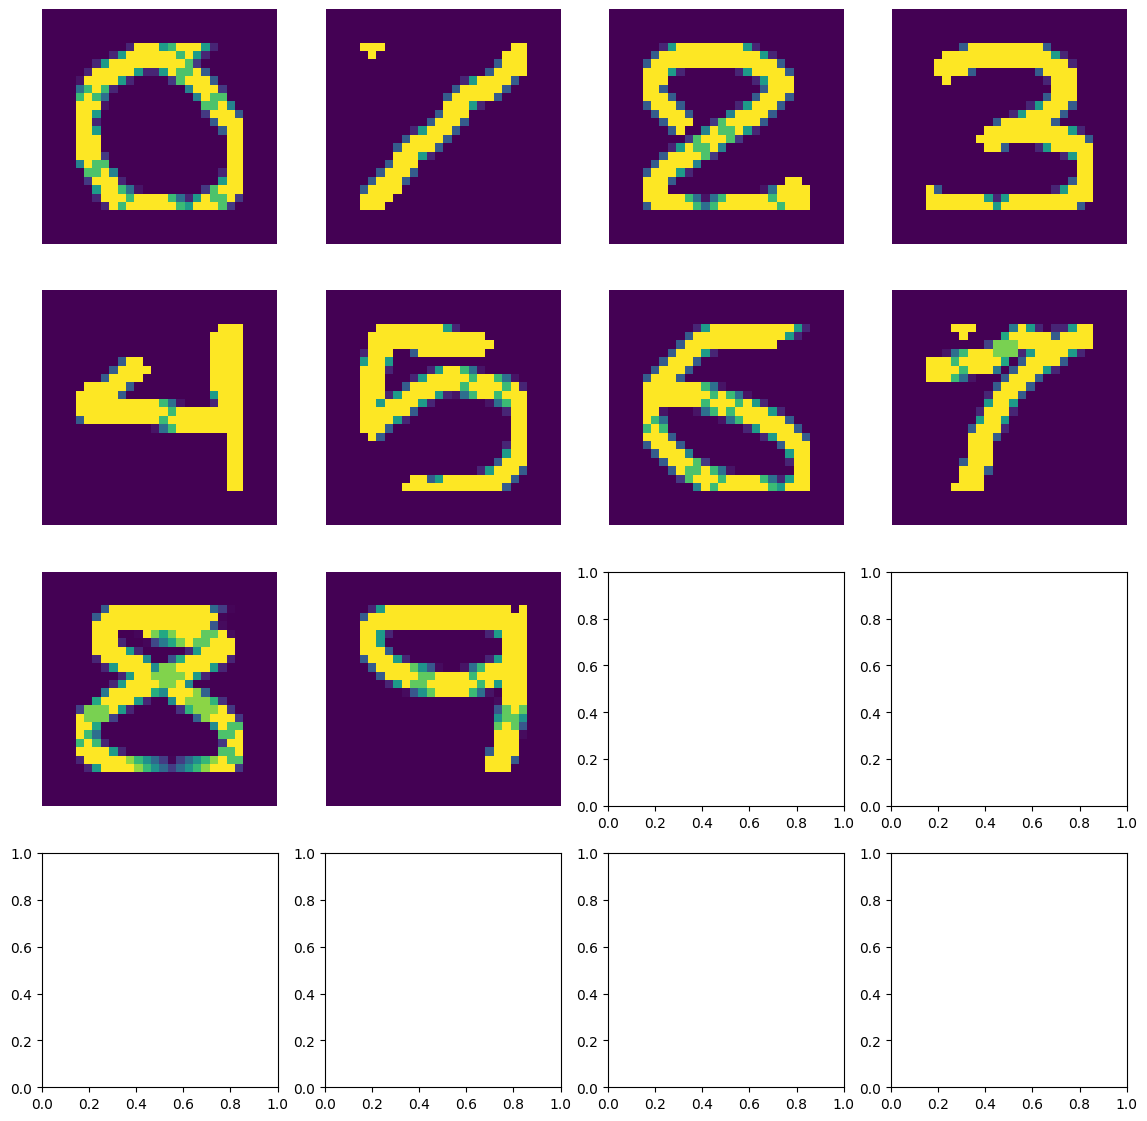

In [11]:
import utils

from skimage.draw import line_aa, line
from skimage.filters import gaussian
from skimage.morphology import dilation, opening, closing, remove_small_objects, binary_erosion, binary_dilation
from skimage.exposure import adjust_log, adjust_sigmoid

def rasterize(points:np.ndarray, gridsize: int,) -> np.ndarray:
        points = (points - points.min(0)) / (points.max(0) - points.min(0))
        points = np.ceil(points * (gridsize-1))
        points = points.astype(int)
        
        im = np.zeros((gridsize, gridsize), np.uint8)
        for i in range(len(points) - 1):
            x, y, _ = points[i]
            x_n, y_n, _ = points[i + 1]
            # rr, cc, val = line_aa(-y, x, -y_n, x_n)
            rr, cc, val = line_aa(-y, x, -y_n, x_n)
            im[rr,cc] = val * 255
        # im = remove_small_objects(im, 4, connectivity=4)
        # im = binary_dilation(im)
        im = dilation(im)
        # im = gaussian(im, sigma=1, preserve_range=True)
        # im = (im - im.min()) / (im.max() - im.min())
        # im = im * 255
        # im = im.clip(0,255).astype(np.uint8)
        return im

fig, ax = plt.subplots(4, 4, figsize=(14,14))

# n = round(1000 ** .5)
for points, axis in zip(data[::100], ax.ravel()):
    im = rasterize(points=points.values, gridsize=28 - 8)
    im = np.pad(im, 4)
    axis.imshow(im)
    axis.axis('off')

In [12]:
im.max(), im.min(), im.mean()

(255, 0, 52.34183673469388)

In [13]:
mnist_x[0].max(), mnist_x.min(), mnist_x[0].mean()

(255, 0, 35.108418367346935)

In [21]:
from tqdm import tqdm
data_x = []
data_y = labels
for points in tqdm(data):
    im = rasterize(points=points.values, gridsize=28 - 8)
    im = np.pad(im, 4)
    data_x.append(im)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1365.48it/s]


In [22]:
data_x = np.stack(data_x)
data_y = labels.values.squeeze()

In [23]:
print(mnist_x.shape, mnist_y.shape, mnist_x.dtype)

(70000, 28, 28) (70000,) uint8


In [141]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split the LM data into 50/50
# Add MNIST to training half, test with only LM held-out dataset.
x_train, x_test, y_train, y_test = train_test_split(
    data_x, 
    data_y, 
    test_size=0.50, 
    shuffle=True,
    stratify=data_y,
    random_state=42,
)

x_train = np.concatenate((mnist_x, x_train))
y_train = np.concatenate((mnist_y, y_train))

N, H, W = x_train.shape
x_train_ = x_train.reshape(N, H * W) / 255
N, H, W = x_test.shape
x_test_ = x_test.reshape(N, H * W) / 255

# clf = SVC(kernel='linear')
# for n in range(1, 10):
#     # clf = KNeighborsClassifier(n_neighbors=n, p = 2)
#     clf = SGDClassifier(n_jobs = 4)
#     # clf = GradientBoostingClassifier()

#     clf.fit(x_train_, y_train)

#     predicted = clf.predict(x_test_)

#     # print(
#     #     f"Classification report for classifier {clf}:\n"
#     #     f"{classification_report(y_test, predicted)}\n"
#     # )
#     print(n, accuracy_score(y_test, predicted))

In [142]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [143]:
x_train = torch.tensor(x_train).float().unsqueeze(1) / 255
y_train = torch.tensor(y_train)
x_test = torch.tensor(x_test).float().unsqueeze(1) / 255
y_test = torch.tensor(y_test)

train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

In [169]:
class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 32, 4),
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 2),
            nn.Dropout2d(.2),
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 2),
            nn.Dropout2d(.2),
            nn.GELU(),
            
            nn.MaxPool2d(2),
            # nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 2),
            nn.Dropout2d(.2),
            nn.GELU(),
            
            # nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Dropout(),
            
            nn.BatchNorm1d(256),
            nn.Linear(256,256),
            nn.GELU(),
            nn.Dropout(),
            
            nn.BatchNorm1d(256),
            nn.Linear(256, 10),
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

learning_rate = 1e-3
batch_size = 64 * 2
epochs = 40

model = Net()
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [170]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.to(device)
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [171]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.526625  [  128/70500]
loss: 0.281769  [12928/70500]
loss: 0.146823  [25728/70500]
loss: 0.112868  [38528/70500]
loss: 0.133599  [51328/70500]
loss: 0.195969  [64128/70500]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.427249 

Epoch 2
-------------------------------
loss: 0.067663  [  128/70500]
loss: 0.099322  [12928/70500]
loss: 0.128178  [25728/70500]
loss: 0.162908  [38528/70500]
loss: 0.056676  [51328/70500]
loss: 0.091220  [64128/70500]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.380434 

Epoch 3
-------------------------------
loss: 0.054251  [  128/70500]
loss: 0.046957  [12928/70500]
loss: 0.087757  [25728/70500]
loss: 0.122559  [38528/70500]
loss: 0.067414  [51328/70500]
loss: 0.012968  [64128/70500]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.391598 

Epoch 4
-------------------------------
loss: 0.114207  [  128/70500]
loss: 0.058365  [12928/70500]
loss: 0.035024  [25728/70500]
loss: 0.098910  [38528/70500]
loss: 0.067058  [51328/7